In [1]:
import pandas as pd
import numpy as np
import os
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

proj_dir = os.path.join(consts['official_indir'], 'WCHS')

In [2]:
figure_outdir = 'figures_revision_filterNAsitesThenTumors'
# figure_outdir = 'figures_revision_filterNA'
# figure_outdir = 'figures_revision_DONTfilterNA'
proj_figure_outdir = os.path.join(figure_outdir, 'WCHS')

os.makedirs(proj_figure_outdir, exist_ok=True)

In [3]:
sample_annotations = pd.read_csv(os.path.join(proj_dir, 'wchs_450k_pheno_data.csv'), index_col=0)
sample_annotations = sample_annotations.rename(index=lambda x:x[1:]) # eliminate X prefix of sample names
sample_annotations['LUMP'] = pd.read_table(os.path.join(proj_dir, 'LUMP_purity.txt'), index_col=0).squeeze('columns')
sample_annotations['tumor_stage'] = 'Stage ' + sample_annotations['tumor_stage'].apply(lambda x:None if np.isnan(x) else str(int(x)))

In [4]:
beta_values_Clock_CpGs_revision_pureSamples = pd.read_table(os.path.join(proj_dir, 'beta_values_Clock_CpGs_revision_pureSamples.txt'), index_col=0)

## Filter sites that have missing values in more than 25% of tumors
mask = beta_values_Clock_CpGs_revision_pureSamples.isna().mean(axis=1) > 0.25
print(f'{np.sum(mask)} CpGs removed for having >25% missing values')
Clock_CpGs_good = mask.index[~mask].values
beta_values_Clock_CpGs_revision_pureSamples = beta_values_Clock_CpGs_revision_pureSamples.loc[Clock_CpGs_good]
##

final_sample_set = beta_values_Clock_CpGs_revision_pureSamples.columns[beta_values_Clock_CpGs_revision_pureSamples.isna().mean(axis=0) < 0.05]


# Count difference in # tumors
n_before = beta_values_Clock_CpGs_revision_pureSamples.shape[1]
n_after = final_sample_set.shape[0]

print(f'{n_before - n_after} tumors were filtered for having >=5% missing values for the {len(Clock_CpGs_good)} selected sites.')
print(f'{n_after} tumors left')

51 CpGs removed for having >25% missing values
114 tumors were filtered for having >=5% missing values for the 449 selected sites.
445 tumors left


Index(['9704031056_R02C02', '9704031090_R05C02', '9704031092_R06C02',
       '9704031117_R05C02', '9721366141_R02C01', '9721367074_R01C01',
       '9769100014_R04C02', '9769100069_R01C01'],
      dtype='object')

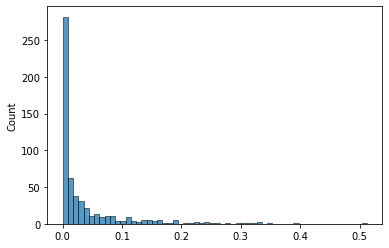

In [5]:
sns.histplot(beta_values_Clock_CpGs_revision_pureSamples.isna().mean(axis=0))
beta_values_Clock_CpGs_revision_pureSamples.columns[beta_values_Clock_CpGs_revision_pureSamples.isna().mean(axis=0) > 0.3]

In [45]:
sample_annotations['c_beta'] = 1 - beta_values_Clock_CpGs_revision_pureSamples.std(axis=0)

# Do not filter by NA
# sample_annotations['in_analysis_dataset'] = sample_annotations.index.isin(beta_values_Clock_CpGs_revision_pureSamples.columns) & (sample_annotations['tumor_stage'] != 'Stage 0')

# Filter by NA
sample_annotations['in_analysis_dataset'] = sample_annotations.index.isin(final_sample_set) & (sample_annotations['tumor_stage'] != 'Stage 0')
print(f'Analysis cohort: n={sample_annotations["in_analysis_dataset"].sum()}')

Analysis cohort: n=445


## EDA

In [7]:
sample_annotations[['ER', 'pr', 'her2']].apply(lambda x:x.unique(), axis=0)

ER                     [positive, negative]
pr                [positive, negative, nan]
her2    [negative, positive, nan, equivoca]
dtype: object

In [8]:
epi_util.getCorrelation(sample_annotations, 'LUMP', 'c_beta')

LinregressResult(slope=-1.2426756404297492, intercept=1.849242129996727, rvalue=-0.5149797546813429, pvalue=3.485985862535169e-39, stderr=0.08764424003838982, intercept_stderr=0.07342116128687297)

### Perform IHC subtyping

In [9]:
marker_state_dict = {
    'equivoca':float('NaN'),
    'negative':'negative', 'positive':'positive'}

for col in ['ER', 'pr', 'her2']:
    sample_annotations[col] = sample_annotations[col].map(marker_state_dict)

sample_annotations['HR+'] = (sample_annotations['ER'] == 'positive') | (sample_annotations['pr'] == 'positive')
sample_annotations['HR-'] = (sample_annotations['ER'] == 'negative') & (sample_annotations['pr'] == 'negative')

sample_annotations['LumA_type'] = sample_annotations['HR+'] & (sample_annotations['her2'] == 'negative')
sample_annotations['LumB_type'] = sample_annotations['HR+'] & (sample_annotations['her2'] == 'positive')
sample_annotations['Her2_type'] = (sample_annotations['her2'] == 'positive') & sample_annotations['HR-']
sample_annotations['Triple-Negative_type'] = sample_annotations['HR-'] & (sample_annotations['her2'] == 'negative')

subtype_list = ['LumA_type', 'LumB_type', 'Her2_type', 'Triple-Negative_type']

for subtype in subtype_list:
    sample_annotations[subtype] = sample_annotations[subtype].map({True:subtype.split('_type')[0], False:''})

sample_annotations['subtype.ihc'] = sample_annotations[subtype_list].apply(lambda row:''.join(row), axis=1)
sample_annotations.loc[sample_annotations['subtype.ihc'] == '', 'subtype.ihc'] = None

### NA Values

In [10]:
sample_annotations.loc[sample_annotations['in_analysis_dataset'], ['ER', 'pr', 'her2']].isna().sum(axis=0)

ER       0
pr      10
her2    23
dtype: int64

## Make Figures

In [11]:
## Configure graph
sf = consts['sf']
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')
sf = 0.4

In [12]:
sample_annotations.name = 'WCHS'

In [39]:
sample_annotations['c_beta'].isna().sum()

135

In [44]:
sample_annotations.loc[sample_annotations['in_analysis_dataset'], 'subtype.ihc'].isna().sum()

24

In [41]:
(sample_annotations['in_analysis_dataset'] & ~sample_annotations['c_beta'].isna()).sum()

445

Medians:


subtype.ihc
Her2               0.851530
LumA               0.848524
LumB               0.860991
Triple-Negative    0.824993
Name: c_beta, dtype: float64

Wilcoxon p-values:


,LumB,Her2,Triple-Negative
LumA,0.095,0.544919,0.000138
LumB,,0.719408,0.000011
Her2,,,0.016849


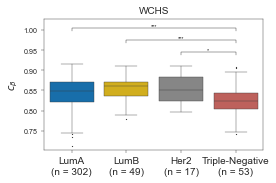

In [35]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='c_beta', restrict=True,
                        var_cat='subtype.ihc', xlabel='',
                        outdir=proj_figure_outdir, title=True,
                        use_groups = ['LumA', 'LumB', 'Her2', 'Triple-Negative'],
                        palette=consts['palette_jco'],
                        figsize=figsize * [1.4, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.23
                       )

print('Medians:')
display(sample_annotations.loc[sample_annotations['in_analysis_dataset']].groupby('subtype.ihc')['c_beta'].median())

print('Wilcoxon p-values:')
display(epi_util.getWilcoxonPvalueTable(sample_annotations.loc[sample_annotations['in_analysis_dataset']],
                                'subtype.ihc', 'c_beta', use_groups=['LumA', 'LumB', 'Her2', 'Triple-Negative']).dropna(how='all', axis=0).dropna(how='all', axis=1).fillna(''))

<Axes: title={'center': 'WCHS'}, ylabel='LUMP Purity'>

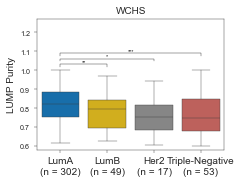

In [32]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='LUMP', restrict=True,
                        var_cat='subtype.ihc', xlabel='',
                        outdir=proj_figure_outdir, title=True, ylabel='LUMP Purity',
                        use_groups = ['LumA', 'LumB', 'Her2', 'Triple-Negative'],
                        palette=consts['palette_jco'],
                        figsize=figsize * [1.2, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.28
                       )

<Axes: title={'center': 'WCHS'}, ylabel='$c_β$'>

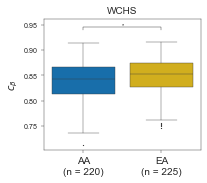

In [21]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='c_beta', restrict=True,
                        var_cat='race', xlabel='Race',
                        outdir=proj_figure_outdir, title=True,
                        palette=consts['palette_jco'],
                        figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.28
                       )

/Users/danielmonyak/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8180: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


<Axes: title={'center': 'WCHS'}, ylabel='$c_β$'>

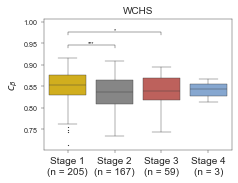

In [30]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='c_beta', restrict=True,
                        var_cat='tumor_stage',
                        xlabel='',
                        outdir=proj_figure_outdir,
                        title=True,
                        palette=consts['palette_jco'],
                        figsize=figsize * [1.2, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.28
                       )

<Axes: title={'center': 'WCHS'}, ylabel='$c_β$'>

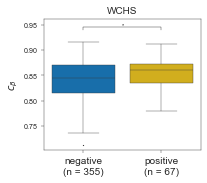

In [23]:
epi_util.saveBoxPlotNew(sample_annotations, var_y='c_beta', restrict=True,
                        var_cat='her2', xlabel='Her2 Positive',
                        outdir=proj_figure_outdir,
                        title=True,
                        palette=consts['palette_jco'],
                        figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'],
                        plot_ymax_mult=0.28
                       )

In [49]:
var_x = 'c_beta'
var_y = 'age'

use_samples = sample_annotations.index[sample_annotations['in_analysis_dataset']].values
res = epi_util.getCorrelation(sample_annotations, var_x=var_x, var_y=var_y, use_samples=use_samples)
pvalue_formatted = f'{res.pvalue:.0e}' if res.pvalue < 0.01 else f'{res.pvalue:.2f}'
print(f'{var_x}: R={res.rvalue:.2f}, P={pvalue_formatted}')

c_beta: R=-0.03, P=0.55


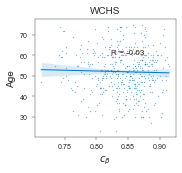

In [24]:
epi_util.saveCorrelationPlot(sample_annotations, var_y='age', restrict=True,
                             var_x='c_beta',
                             outdir=proj_figure_outdir,
                             ylabel='Age',
                             text_x=0.85, text_y=60,
                             figsize=figsize * 0.9, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1 * sf,
                             color=consts['palette_jco'][0], line_kws={'linewidth':1}
                            )

In [25]:
from MolecularClocks.src.merge_pdfs import merge_pdfs
merge_pdfs(
    [os.path.join(proj_figure_outdir, filename) for filename in os.listdir(proj_figure_outdir) if filename.endswith('.pdf')],
    os.path.join(proj_figure_outdir, f'merged_{figure_outdir}.pdf')
)